## Analytical versus numerical solution of the Geometric Brownian Motion (GBM) Equation

The random process $X(t)$ is said to follow a Geometric Brownian Motion (Wiener) process with drift $\mu$ and diffusion coefficient $ \sigma^{2} $ if $X(t)$ is a solution of the Stochastic Differential Equation (SDE):

$$ \frac{dX\left(t\right)}{X(t)} = \mu{dt}+\sigma{dW(t)} $$

where $dW(t)$ is a one-dimensional Wiener Process and $\mu$ and $\sigma>0$ are constants. We developed both the analytical and approximate numerical solution to the geometric brownian motion stochastic differential equation. The analytical solution is given by:

$$ X(t) = X_{o}\exp\left(\left(\mu - \frac{\sigma^{2}}{2}\right)t+\sigma{W}(t)\right) $$

while the approximate [Euler–Maruyama](https://en.wikipedia.org/wiki/Euler–Maruyama_method) solution is given by:

$$ X_{k+1} = X_{k}\left(1+\mu{h}+\sigma\sqrt{h}\times{Z\left(0,1\right)}\right)\qquad{k=1,2,\dots,N-1} $$

where $X_{\star}$ denotes the approximate solution at time step $\star$, 
$h$ denotes the time step size, and $Z\left(0,1\right)$ denotes a standard normal random variable.


### Data: Daily close price of SPY

In [1]:
# Load the required packages -
using DataFrames, CSV, Plots, Dates, Statistics, LinearAlgebra, Distributions

In [2]:
# Load SP500 OHLC data between 12/19 to 12/21 (SPY.csv) -
df = CSV.read(joinpath("./data/SPY-Dec-2019-to-Dec-2021.csv"), DataFrame)

# Sort the data from 12/21 to 12/19 -
df_rev = sort(df, [order(:timestamp, rev=true), :close]);

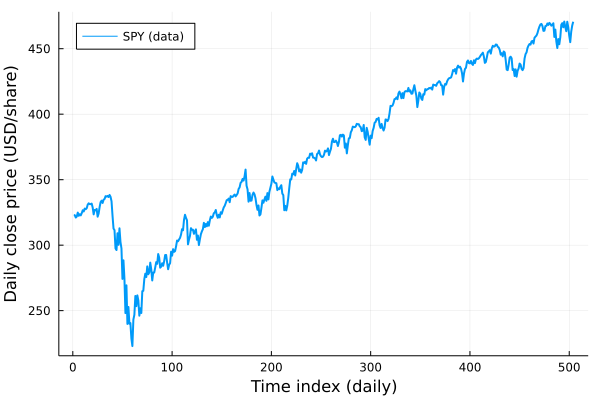

In [3]:
# plot the close price -
plot(df[!,:close], lw=2, legend=:topleft, label="SPY (data)")
xlabel!("Time index (daily)", fontsize=18)
ylabel!("Daily close price (USD/share)", fontsize=18)

### Estimate the $\mu$ and $\sigma$ parameters from SPY price data

#### Drift parameter $\mu$

In [4]:
# setup -
AF = 252
Δt = (1/AF) # we use the 252-day convention
time_index_start = 100 # let's neglect the March 2020 meltdown
N = length(df[!,:close]);

# initialize some temp storage -
μ_log_array = Array{Float64,1}()

# compute the unweighted return -
for k ∈ time_index_start:(N-1)
    
    # get the close prices from the data frame -
    P₁ = df[k,:close]
    P₂ = df[k+1,:close]

    # what is the μ value?
    μ_log_value = log(P₂/P₁)
    
    # capture -
    push!(μ_log_array, μ_log_value)
end

# what is the average value and std?
μ_average = mean(μ_log_array);

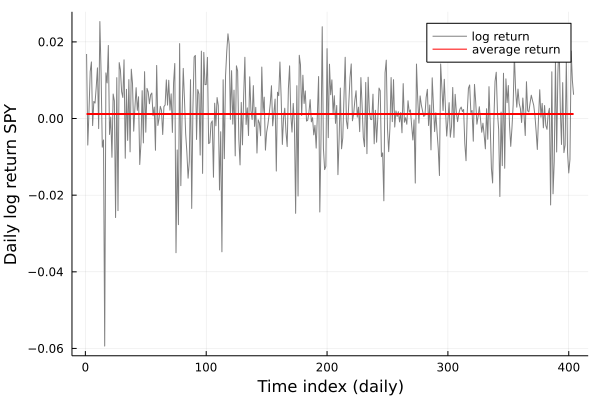

In [5]:
# show the actual and the mean -
μ_average_array = μ_average*ones(length(μ_log_array))
plot(μ_log_array,lw=1,label="log return", c=:gray)
plot!(μ_average_array,lw=2,label="average return", c=:red)
xlabel!("Time index (daily)", fontsize=18)
ylabel!("Daily log return SPY", fontsize=18)

In [6]:
SPY_actual = df[time_index_start:end,:close];
y = log.(SPY_actual)
T = (1/AF)*(range(0,step=1,length=405) |> collect) # units: years (convention: annualized)
X = [T ones(405)];
θ = inv(transpose(X)*X)*transpose(X)*y

# compute the lsq end point -
Xₒ = SPY_actual[1]
Xₒ_lsq = exp(θ[2])
X_lsq = Xₒ_lsq*exp.(θ[1]*T);

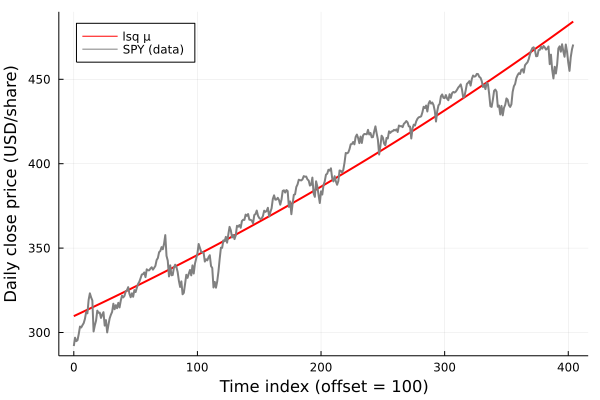

In [7]:
# plot -
plot(T*AF, X_lsq, lw=2, label="lsq μ", c=:red)
plot!(T*AF, SPY_actual, lw=2, legend=:topleft, label="SPY (data)", c=:gray)
xlabel!("Time index (offset = 100)", fontsize=18)
ylabel!("Daily close price (USD/share)", fontsize=18)

#### Diffusion parameter $\sigma$

In [8]:
# compute euler approx -
number_of_sample_paths = 50
X_analytical = Array{Float64,2}(undef, length(T), number_of_sample_paths)
X_analytical[1,:] .= Xₒ
μ = θ[1]
σ = sqrt(AF)*std(μ_log_array) # annualized volatility

# precompute the W terms -
d = Normal(0,1)
Z = rand(d,length(T),number_of_sample_paths)

# main loop -
for s = 1:number_of_sample_paths
    for t = 1:length(T)-1
        
        # compute the terms -
        term_1 = (μ-(σ^2)/2)*Δt + σ*sqrt(Δt)*Z[t,s]
        X_analytical[t+1,s] = X_analytical[t,s]*exp(term_1)
    end
end

In [11]:
σ

0.15518567695495852

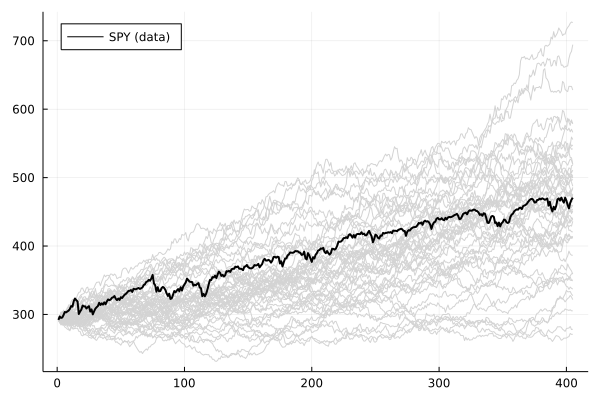

In [10]:
IR = 1:405
plot(X_analytical[IR,:], label="", c=:lightgray)
plot!(SPY_actual[IR], lw=2, legend=:topleft, label="SPY (data)", c=:black)
